In [1]:
%pip install pandas numpy scikit-learn tensorflow tqdm imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
version = 0

# Models

The current models being implemented are namely:

* Supervised
    1. Logistic Regression Model
    2. Random Forest Classifier
    3. Support Vector Machine
    4. Deep Neural Network
    5. (New) Bayesian Network
    6. (New) Gradient Boosting

* Unsupervised
    1. (New) K-Means Clustering
    2. (New) Kernel Density Estimation

In [3]:
import importlib
import pandas as pd
import plotter
import numpy as np

# Selecting column names for CESD-10 Scale related features
cesd_col_names = ["_a_emobth", "_a_emomnd", "_a_emodep", "_a_emoeff", "_a_emohope",
                "_a_emofear", "_a_emoslp", "_a_emohap", "_a_emolone", "_a_emogo"]

cesd_col_names_w1 = ["w1" + col for col in cesd_col_names]
cesd_col_names_w2 = ["w2" + col for col in cesd_col_names]
cesd_col_names_w3 = ["w3" + col for col in cesd_col_names]
cesd_col_names_w4 = ["w4" + col for col in cesd_col_names]
cesd_col_names_w5 = ["w5" + col for col in cesd_col_names]

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def print_correlations(df):
    correlation_df = df.drop(columns=['pid'])

    # Compute correlation matrix
    correlation_matrix = correlation_df.corr()

    # Display top of correlation matrix for quick review
    # print(correlation_matrix)

    num_features = 4
    check = 'score'

    # Get correlations with the 'depressed' feature
    depressed_corr = correlation_matrix[check].drop(check).drop('depressed')  # Drop self-correlation

    # Sort the correlations in descending order (absolute values can be used for both + and - correlations)
    top_10_corr = depressed_corr.abs().sort_values(ascending=False).head(num_features)
    cols = [i for i in top_10_corr.index.to_list()]
    cols.append(check)

    # Display the top 10 correlated features with 'depressed'
    print(f"Top {num_features} features most correlated with '{check}':")
    print(top_10_corr)

    # For specific features (e.g., top 5 features)
    sns.pairplot(correlation_df[cols])
    plt.show()


### Prepping dataset

In [5]:
df1 = pd.read_csv("CSV/wave1_select_labelled.csv")
df1 = df1.drop(columns=cesd_col_names_w1)
print(df1['pid'].count())

df2 = pd.read_csv("CSV/wave2_select_labelled.csv")
df2 = df2.drop(columns=cesd_col_names_w2)
print(df2['pid'].count())

df3 = pd.read_csv("CSV/wave3_select_labelled.csv")
df3 = df3.drop(columns=cesd_col_names_w3)
print(df3['pid'].count())

df4 = pd.read_csv("CSV/wave4_select_labelled.csv")
df4 = df4.drop(columns=cesd_col_names_w4)
print(df4['pid'].count())

df5 = pd.read_csv("CSV/wave5_select_labelled.csv")
df5 = df5.drop(columns=cesd_col_names_w5)
print(df5['pid'].count())

combined_df = pd.concat([df1, df2, df3, df4, df5], axis=0, ignore_index=True)
print(combined_df['pid'].count())
print(combined_df.columns, f"\n{len(combined_df.columns) - 1} columns")

# print(combined_df.describe())

14156
14589
14746
19294
18779
81564
Index(['pid', 'age', 'gender', 'race', 'marital_status', 'born_province',
       'employed', 'employed_take_home', 'employed_weekly_hours',
       'self_employed', 'self_employed_take_home',
       'self_employed_weekly_hours', 'casual_work', 'casual_weekly_hours',
       'highest_grade_school', 'tertiary_education', 'currently_enrolled',
       'fever', 'persistent_cough', 'cough_with_blood', 'chest_pain',
       'body_ache', 'headache', 'back_ache', 'joint_pain_arthritis',
       'diarrhoea', 'painful_urination', 'swelling_ankles',
       'severe_weight_loss', 'time_since_prev_consulation', 'had_tubercolosis',
       'had_high_blood_pressure', 'had_diabetes_or_high_blood_sugar',
       'had_stroke', 'had_asthma', 'had_heart_problems', 'had_cancer',
       'exercise_frequency', 'smokes_cigarettes', 'height_measurement',
       'weight_measurement', 'waist_measurement', 'score', 'depressed'],
      dtype='object') 
43 columns


Top 4 features most correlated with 'score':
age                      0.133990
employed_weekly_hours    0.077481
marital_status           0.073908
height_measurement       0.066803
Name: score, dtype: float64
['age', 'employed_weekly_hours', 'marital_status', 'height_measurement']
Strong correlations (above 0.7 or below -0.7):
Highly correlated feature pairs:
swelling_ankles     painful_urination     0.821589
painful_urination   swelling_ankles       0.821589
cough_with_blood    had_cancer            0.816307
had_cancer          cough_with_blood      0.816307
                    had_stroke            0.810218
had_stroke          had_cancer            0.810218
had_cancer          had_heart_problems    0.791126
had_heart_problems  had_cancer            0.791126
score               depressed             0.790721
depressed           score                 0.790721
cough_with_blood    diarrhoea             0.771701
diarrhoea           cough_with_blood      0.771701
cough_with_blood    had_st

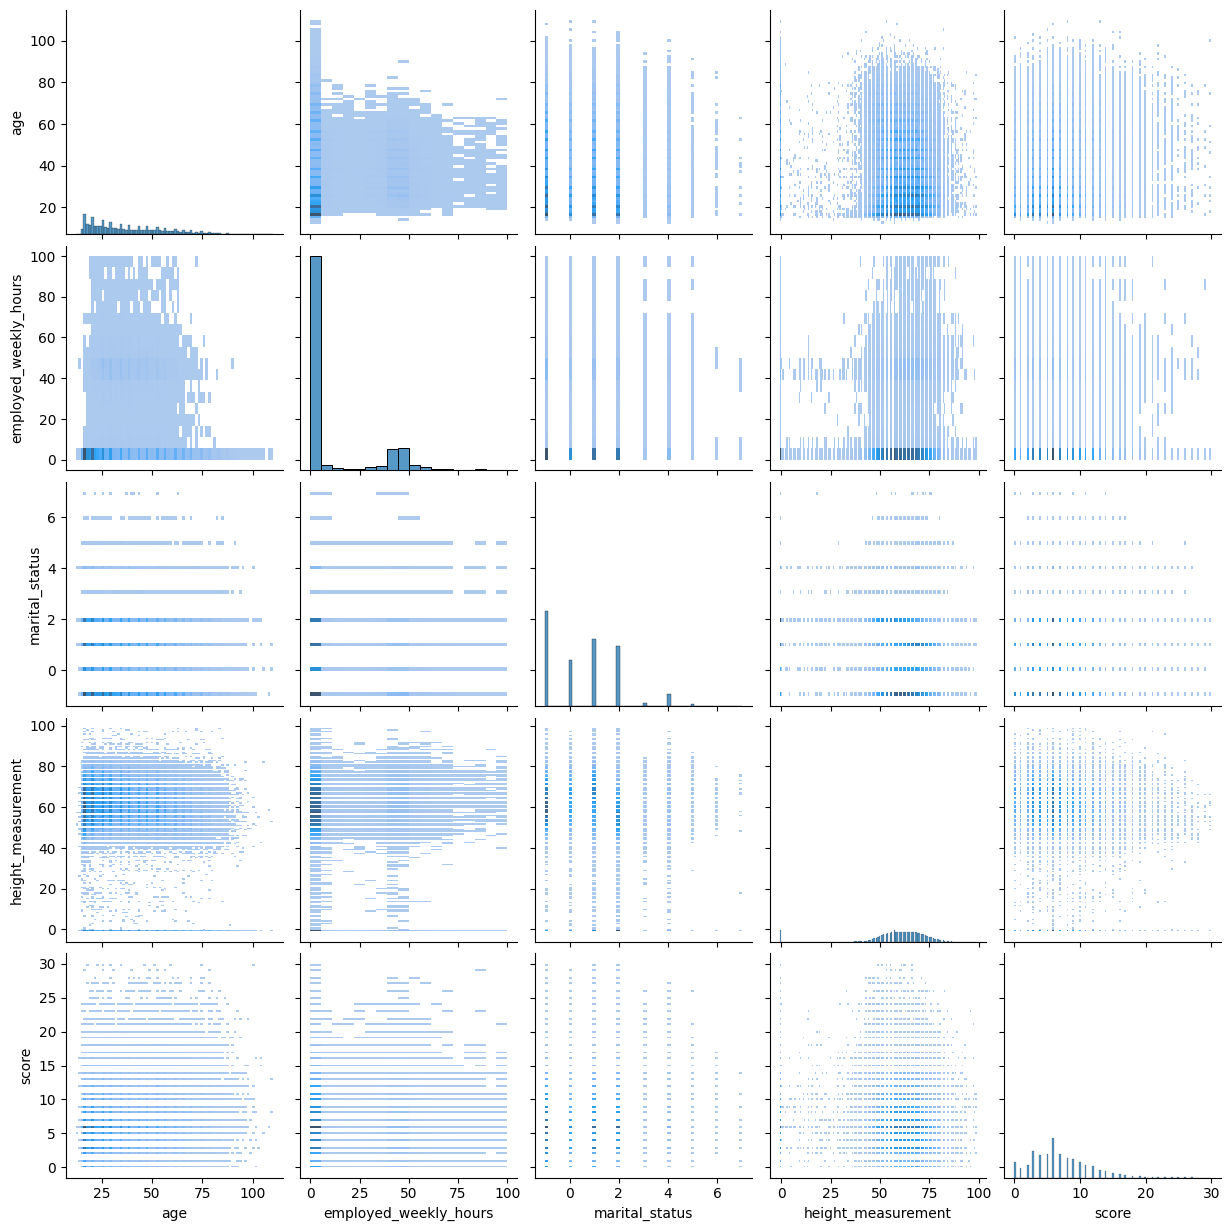

In [6]:
correlation_df = combined_df.drop(columns=['pid'])

# Compute correlation matrix
correlation_matrix = correlation_df.corr()

# Display top of correlation matrix for quick review
# print(correlation_matrix)

num_features = 4
check = 'score'

# Get correlations with the 'depressed' feature
depressed_corr = correlation_matrix[check].drop(check).drop('depressed')  # Drop self-correlation

# Sort the correlations in descending order (absolute values can be used for both + and - correlations)
top_10_corr = depressed_corr.abs().sort_values(ascending=False).head(num_features)
cols = [i for i in top_10_corr.index.to_list()]
cols.append(check)

# Display the top 10 correlated features with 'depressed'
print(f"Top {num_features} features most correlated with '{check}':")
print(top_10_corr)
print(list(top_10_corr.index.to_list()))

# Set a threshold for strong correlations
threshold = 0.7

# Filter the correlation matrix
strong_corr = correlation_matrix[(correlation_matrix.abs() >= threshold) & (correlation_matrix != 1.0)]

print(f"Strong correlations (above {threshold} or below -{threshold}):")
# print(strong_corr)

# Extract upper triangle correlations
def get_highly_correlated_pairs(corr_matrix, threshold=0.8):
    corr_pairs = corr_matrix.unstack()
    high_corr_pairs = corr_pairs[(corr_pairs.abs() > threshold) & (corr_pairs != 1)].sort_values(ascending=False)
    return high_corr_pairs

# Get highly correlated pairs with threshold 0.8
high_corr_pairs = get_highly_correlated_pairs(correlation_matrix, threshold=0.7)

print("Highly correlated feature pairs:")
print(high_corr_pairs)

from sklearn.decomposition import PCA

# Standardize the data (mean=0, variance=1) before applying PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(correlation_df)

# Apply PCA
pca = PCA(n_components=5)  # You can set the number of principal components
pca_result = pca.fit_transform(scaled_data)

# Explained variance ratio of each component
print("Explained variance by each principal component:")
print(pca.explained_variance_ratio_)

import seaborn as sns
import matplotlib.pyplot as plt

# For specific features (e.g., top 5 features)
sns.pairplot(correlation_df[cols], kind='hist')
plt.show()


### Additional Preprocessing

121936


/home/useradd/GITHUB/Research/Implementation/plotter.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(value_counts.index, rotation=rotation)


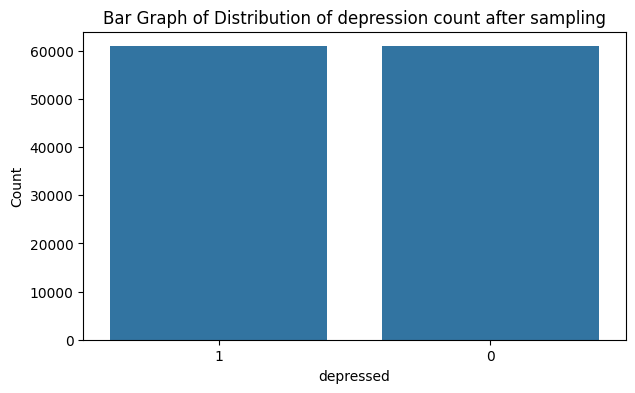

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import plotter

combined_df = combined_df.drop(columns=["score"])

'''
SMOTE
'''
if version == 0:
    # Split data into features (X) and target (y)
    X = combined_df.drop('depressed', axis=1)
    y = combined_df['depressed']

    # Apply SMOTE for oversampling or RandomUnderSampler for undersampling
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Or for undersampling
    # undersample = RandomUnderSampler()
    # X_resampled, y_resampled = undersample.fit_resample(X, y)

    # Combine back into a balanced dataframe
    df_balanced = pd.concat([X_resampled, y_resampled], axis=1)
    combined_df = df_balanced

    print(combined_df['pid'].count())

    plotter.plot_bar(combined_df['depressed'], "Distribution of depression count after sampling")

if version == 1:
    # Separate majority and minority classes
    majority_class = combined_df[combined_df['depressed'] == 0]
    minority_class = combined_df[combined_df['depressed'] == 1]

    # Oversample the minority class to match the number of majority class samples
    oversampled_minority = minority_class.sample(len(majority_class), replace=True)

    # Concatenate the majority class with the oversampled minority class
    df_balanced = pd.concat([majority_class, oversampled_minority])

    # Shuffle the dataset
    df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

    combined_df = df_balanced

    plotter.plot_bar(combined_df['depressed'], "Distribution of depression count after sampling")

Precision = TP / TP + FP (How often are positive predictions correct?)
Recall = TP / TP + FN (Can an ML model find all instances of the positive class?)

In [8]:
OPTIMIZE = True

if version == 0:
    combined_df.to_pickle("CSV/waves_combined_smote_sampling.pkl")
    combined_df.to_csv("CSV/waves_combined_smote_sampling.csv")
if version == 1:
    combined_df.to_pickle("CSV/waves_combined_pandas_sampling.pkl")
    combined_df.to_csv("CSV/waves_combined_pandas_sampling.csv")

In [10]:
reduced_df = combined_df.drop(['fever', 'persistent_cough', 'cough_with_blood',
                               'chest_pain', 'body_ache', 'headache', 'back_ache',
                               'joint_pain_arthritis', 'diarrhoea', 'painful_urination',
                               'swelling_ankles'], axis=1)

combined_df.to_pickle("CSV/waves_reduced.pkl")